In [1]:
""" Form Google search urls for scraping """

ORIG_URL = 'https://www.google.com/search?q=carbon+footprint'

page_amount = 11
URLS = [ORIG_URL + '&start=' + str(i*10) for i in range(0, page_amount)]
print(URLS)

['https://www.google.com/search?q=carbon+footprint&start=0', 'https://www.google.com/search?q=carbon+footprint&start=10', 'https://www.google.com/search?q=carbon+footprint&start=20', 'https://www.google.com/search?q=carbon+footprint&start=30', 'https://www.google.com/search?q=carbon+footprint&start=40', 'https://www.google.com/search?q=carbon+footprint&start=50', 'https://www.google.com/search?q=carbon+footprint&start=60', 'https://www.google.com/search?q=carbon+footprint&start=70', 'https://www.google.com/search?q=carbon+footprint&start=80', 'https://www.google.com/search?q=carbon+footprint&start=90', 'https://www.google.com/search?q=carbon+footprint&start=100']


In [2]:
# How to scrape HTML documents from Terminal
# wget --referer="http://www.google.com" --user-agent="Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"   --header="Accept:text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5"   --header="Accept-Language: en-us,en;q=0.5"   --header="Accept-Encoding: gzip,deflate"   --header="Accept-Charset: ISO-8859-1,utf-8;q=0.7,*;q=0.7"   --header="Keep-Alive: 300" "$@" -q -O - https://www.google.com/search?q=carbon+footprint | gzip -dc > test.html


In [3]:
""" Scrape Google search results """

import requests

s = requests.Session()
s.headers = {
    "referer" : "http://www.google.com",
    "user-agent" : "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"
}

def get_response(url):
    resp = s.get(url)
    if resp.status_code != 200:
        print(resp.text)
        raise
    return resp

responses = [get_response(URL) for URL in URLS]

print(responses)

[<Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>, <Response [200]>]


In [4]:
""" Parse scraped Google search results """

from bs4 import BeautifulSoup

def get_description(response):
    returnable=[]
    soup = BeautifulSoup(response.content, "html.parser")
    for s in soup.find_all("div", class_="g"):
        spans = s.find_all('span', class_=None)
        without_attrs = [s for s in spans if (s.attrs == {})]
        without_feedback = [s for s in without_attrs if 'Feedback' != s.text]
        without_cached = [s for s in without_feedback if 'Cached' != s.text]
        without_similar = [s for s in without_cached if 'Similar' != s.text]
        without_cachedsimilar = [s for s in without_similar if 'CachedSimilar' != s.text]
        for desc in without_cachedsimilar:
            desc_text = desc.text
            returnable.append(desc_text.replace('\xa0', ' '))
    return returnable

descriptions_of_pages = [get_description(res) for res in responses]

def flatten(t):
    return [item for sublist in t for item in sublist]

bs4_scraped_snippets = flatten(descriptions_of_pages)

print(*bs4_scraped_snippets, sep='\n')
# Possibly not usable data atm
# Although it doesn't cost anything to calc the metrics for this data also

Leading online carbon footprint calculation tools and information to help reduce and offset your emissions - for business and individuals.
Use the World's most popular online carbon footprint calculator, and it's FREE. Calculate your carbon emissions from Buildings, Cars, Flights and other ...
Leading online carbon footprint calculation tools and information to help reduce and offset your emissions - for business and individuals.
Use the World's most popular online carbon footprint calculator, and it's FREE. Calculate your carbon emissions from Buildings, Cars, Flights and other ...
The calculator estimates your footprint in three areas: home ... You can get a quick, rough estimate of your carbon footprint by using U.S. ...
A carbon footprint is the total greenhouse gas (GHG) emissions caused by an individual, event, organization, service, place or product, expressed as carbon ...
Today, the term “carbon footprint” is often used as shorthand for the amount of carbon (usually in tonnes)

In [5]:
""" Manually scraped snippets """

import csv

# Manually scraped data
# Done 06.10.2021, Oulu Finland
# URL = https://www.google.com/search?q=carbon+footprint
# Selecting next page by clicking

with open('NLP_Carbon_Footprint_Google.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    manually_scraped_snippets = [row[2] for row in csv_reader]
    
print(*manually_scraped_snippets, sep='\n')
        

A carbon footprint is the total amount of greenhouse gases (including carbon dioxide and methane) that are generated by our actions. ... To have the best chance of avoiding a 2℃ rise in global temperatures, the average global carbon footprint per year needs to drop under 2 tons by 2050.
Leading online carbon footprint calculation tools and information to help reduce and offset your emissions - for business and individuals. Free calculators · ‎Calculate · ‎About Us · ‎Business Carbon Footprint...
Use the World's most popular online carbon footprint calculator, and it's FREE. Calculate your carbon emissions from Buildings, Cars, Flights and other ...
A carbon footprint is the total greenhouse gas (GHG) emissions caused by an individual, event, organization, service, place or product, expressed as carbon ... Background · ‎Measuring carbon footprints · ‎Causes · ‎Reducing carbon footprints
14.7.2016 — Many of our daily activities - such as using electricity, driving a car, or disposing of 

In [6]:
""" FuzzyWuzzy """

from fuzzywuzzy import fuzz
import numpy as np

# calculate the score of string matching of each pair
#score = fuzz.ratio("ekan snippetin teksti", "tokan snippetin teksti")

def calc_fuzz_values(doc1, doc2):
    score_list = []
    V1 = 0

    test_snippet = zip(doc1, doc2)

    for sentence1, sentence2 in test_snippet:
        ratio = fuzz.ratio(sentence1, sentence2)
        # V1 corresponding to the total number of similar snippets (string matching score equals 100%)
        if ratio == 100:
            V1 += 1
        score_list.append(ratio)

    # V2 for the average string matching of all pairs
    V2 = np.average(score_list)
    # V3 for the standard deviation corresponding to this average value.
    V3 = np.std(score_list)

    print(V1,V2,V3)

calc_fuzz_values(manually_scraped_snippets[0], manually_scraped_snippets[1])
calc_fuzz_values(manually_scraped_snippets[1], manually_scraped_snippets[2])
calc_fuzz_values(manually_scraped_snippets[3], manually_scraped_snippets[4])

8 3.7735849056603774 19.055669695022786
9 5.806451612903226 23.38654059405401
9 5.660377358490566 23.108393799841302


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Manual

 Preprocessed Data:  carbon footprint total amount greenhouse gases ( including carbon dioxide methane ) generated actions . ... best chance avoiding 2℃ rise global temperatures , average global carbon footprint per year needs drop 2 tons 2050. leading online carbon footprint calculation tools information help reduce offset emissions - business individuals . free calculators · ‎calculate · ‎about us · ‎business carbon footprint ... use world 's popular online carbon footprint calculator , 's free . calculate carbon emissions buildings , cars , flights ... carbon footprint total greenhouse gas ( ghg ) emissions caused individual , event , organization , service , place product , expressed carbon ... background · ‎measuring carbon footprints · ‎causes · 

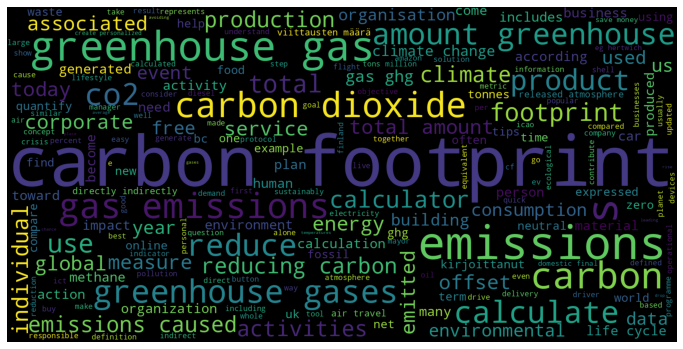

BS4

 Preprocessed Data:  leading online carbon footprint calculation tools information help reduce offset emissions - business individuals . use world 's popular online carbon footprint calculator , 's free . calculate carbon emissions buildings , cars , flights ... leading online carbon footprint calculation tools information help reduce offset emissions - business individuals . use world 's popular online carbon footprint calculator , 's free . calculate carbon emissions buildings , cars , flights ... calculator estimates footprint three areas : home ... get quick , rough estimate carbon footprint using u.s. ... carbon footprint total greenhouse gas ( ghg ) emissions caused individual , event , organization , service , place product , expressed carbon ... today , term “ carbon footprint ” often used shorthand amount carbon ( usually tonnes ) emitted activity organization . ... carbon footprint total amount greenhouse gas emissions come production , use end-of-life product service . 

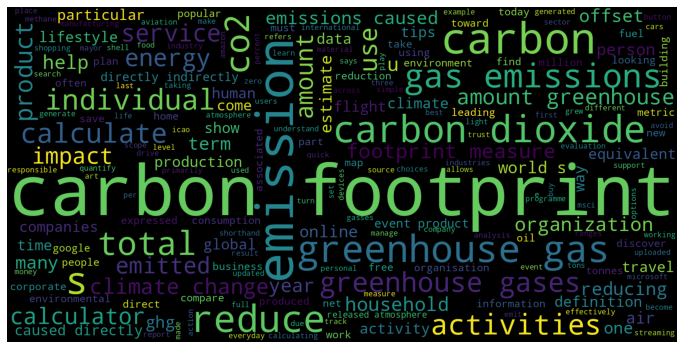

In [56]:
""" WordCloud """

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

class WordCloudGeneration:
    def preprocessing(self, data):
        # convert all words to lowercase
        data = [item.lower() for item in data]
        # load the stop_words of english
        stop_words = set(stopwords.words('english'))
        # concatenate all the data with spaces.
        paragraph = ' '.join(data)
        # tokenize the paragraph using the inbuilt tokenizer
        word_tokens = word_tokenize(paragraph) 
        # filter words present in stopwords list 
        preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
        print("\n Preprocessed Data: " ,preprocessed_data)
        return preprocessed_data

    def create_word_cloud(self, final_data):
        # initiate WordCloud object with parameters width, height, maximum font size and background color
        # call the generate method of WordCloud class to generate an image
        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="black").generate(final_data)
        # plt the image generated by WordCloud class
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

# you may uncomment the following line to use custom input
# input_text = input("Enter the text here: ")
# input_text = 'These datasets are used for machine-learning research and have been cited in peer-reviewed academic journals. Datasets are an integral part of the field of machine learning. Major advances in this field can result from advances in learning algorithms (such as deep learning), computer hardware, and, less-intuitively, the availability of high-quality training datasets.[1] High-quality labeled training datasets for supervised and semi-supervised machine learning algorithms are usually difficult and expensive to produce because of the large amount of time needed to label the data. Although they do not need to be labeled, high-quality datasets for unsupervised learning can also be difficult and costly to produce.'
# input_text = input_text.split('.')

print('Manual')
manual_wordcloud_generator = WordCloudGeneration()
manual_clean_data = manual_wordcloud_generator.preprocessing(manually_scraped_snippets)
manual_wordcloud_generator.create_word_cloud(manual_clean_data)

print('BS4')
bs4_wordcloud_generator = WordCloudGeneration()
bs4_clean_data = bs4_wordcloud_generator.preprocessing(bs4_scraped_snippets)
bs4_wordcloud_generator.create_word_cloud(bs4_clean_data)

In [60]:
#Sentiment analysis
from textblob import TextBlob
#print(manually_scraped_snippets[15])

#temp = TextBlob(manually_scraped_snippets[0])

#for sentence in temp.sentences:
#    print(sentence)
#    print(sentence.sentiment.polarity)

#sen = temp.sentiment
#print(sen)  
polarity = []
for snippet in manually_scraped_snippets:
    text_blob = TextBlob(snippet)
    for sentence in text_blob.sentences:
        polarity.append(sentence.sentiment.polarity)

print(polarity)
pol = polarity.shape((2,99))
#vector 4, average values 

#vector 5, std values

[0.0, 0.2125, 0.0, 0.4, 0.5, -0.125, 0.0, 0.075, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25, 0.0, 0.03333333333333333, 0.2, 0.0, 0.0, -0.125, 0.1, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.5, 0.03333333333333333, 0.0, 0.0, 0.0, 0.4, 0.0, -0.1, 0.0, 0.05, 0.10714285714285714, 0.4, 0.5, 0.5, 0.1, 0.0, 0.155, 0.1, 0.0, 0.0, 0.0, 0.0, -0.16666666666666666, 0.2, 0.45714285714285713, 0.05833333333333335, 0.6, 0.35, 0.0, 0.2, 0.0, 0.6, -0.16666666666666666, 0.0, 0.0, -0.4, 0.24545454545454545, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.4, 0.0, 0.0, 0.0, -0.1, 0.25, 0.21428571428571427, 0.0, 0.0, 1.0, 0.0, 0.0, 0.45, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.1, 0.0, 0.2, 0.16666666666666666, 0.05, 0.12878787878787878, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, -0.2153846153846154, 0.08333333333333333, 0.1, 0.0, 0.0, 0.0, 0.0, -0.0625, 0.0, 0.6, 0.0, 0.2, 0.0, 0.0, 0.0, 0.3666666666666667, 0.0, 0.0, 0.3833333333333333, 0.0, 0.2, 0.0, 0.0, 0.13636363636363635, 0.0, 0.0, 0.4, 0.0, 0.037500000000000006, 0.0, 0.

AttributeError: 'list' object has no attribute 'shape'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df8df42c-8503-4bb3-8c9d-497cf36bf82c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>